In [1]:
import warnings
warnings.filterwarnings('ignore')
from os import walk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import re
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import roc_curve, accuracy_score
from sklearn import model_selection, datasets
import matplotlib.pyplot as plt

In [ ]:
X = []
Y = []

In [3]:
def setData(file):
    header = file.readline()
    empty_row = file.readline()
    message = file.readline()
    X.append(np.array(" ".join(header.split()[1:]) + " " + message).astype(str))

In [4]:
def setTarget(file):
    legit_mark = re.search("^.*legit.*$", file)
    if(legit_mark):
        Y.append(-1)
    else:
        Y.append(1)

In [5]:
def parseMessage(filepath):
    with open(filepath, "r") as file:
        setTarget(filepath)
        setData(file)

In [6]:
for n in range(1, 11):
    for (dirpath, dirnames, filenames) in walk("./messages/part" + str(n) +"/"):
        for filename in filenames:
            parseMessage("./messages/part" + str(n) +"/" + filename)
        break

In [7]:
Y = np.array(Y)
X = np.array(X)

In [8]:
X_transformed = CountVectorizer().fit_transform(X).toarray()

In [9]:
pd.DataFrame(X_transformed, columns = CountVectorizer().fit(X).get_feature_names())

,10,100,1000,10000,10001,10002,10003,10004,10005,10006,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1086,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,2,0,0
1087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1088,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
fog_gc = []

In [11]:
tmp = np.array([0.1, 0.3, 0.5, 0.2, 0.6])

In [12]:
for n in range(0, 3):
    tmp_alpha1 = np.arange(0.00001, 1, 0.5).reshape(-1, 1)
    tmp_alpha2 = np.array([tmp[n]] * len(tmp_alpha1)).reshape(-1, 1)
    
    fog_gc = fog_gc + np.append(tmp_alpha2, tmp_alpha1, axis = 1).tolist()

In [13]:
parameters_grid = {
    'class_prior': fog_gc,
    'alpha':  np.arange(0.0000001, 0.005, 10)
}

In [14]:
sv = GridSearchCV(BernoulliNB(), parameters_grid, scoring="f1", cv=10).fit(X_transformed, Y)

In [15]:
sv.best_estimator_
#BernoulliNB(alpha=1e-07, binarize=0.0, class_prior=[0.1, 0.50001], fit_prior=True)

BernoulliNB(alpha=1e-07, binarize=0.0, class_prior=[0.1, 0.50001],
            fit_prior=True)

In [16]:
sv.best_score_

0.9656009356120886

In [17]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X_transformed, Y, test_size = 0.2)

In [18]:
from sklearn.metrics import confusion_matrix

clf1 = BernoulliNB(alpha=1e-07, binarize=0.0, class_prior=[0.1, 0.50001], fit_prior=True)
print(confusion_matrix(test_labels, clf1.fit(train_data, train_labels).predict(test_data)))

[[118   0]
 [  5  95]]


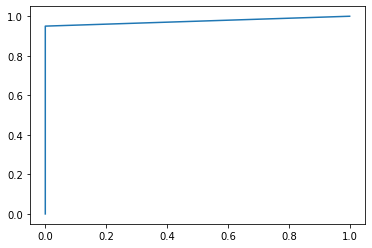

In [19]:
frp, trp, thresholds = roc_curve(test_labels, clf1.fit(train_data, train_labels).predict(test_data))
plt.plot(frp, trp)

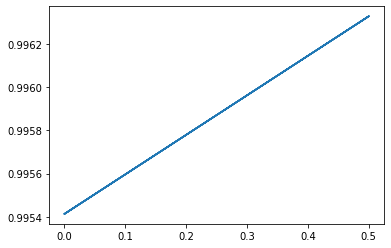

In [20]:
scores = []
alpha = []

for i in fog_gc:
    clf = BernoulliNB(alpha=1e-07, class_prior=i)
    clf = clf.fit(X_transformed, Y)
    scores.append(accuracy_score(Y, clf.predict(X_transformed)))
    alpha.append(i[1])
    
plt.plot(alpha, scores)